In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import scipy.stats as stats
warnings.filterwarnings('ignore')

# Loading

In [5]:
weeks = [f"Quiz #{i}" for i in range (1, 12)]

In [6]:
df_load = pd.read_json('merged_logs.jsonl', lines=True, convert_dates=['_creationTime'])

In [7]:
df  = df_load.copy()
weeks = [f"Quiz #{i}" for i in range (1, 12)]
if True :
    df = df[df['valid']]
df = df.drop_duplicates(subset=['_id'])
before = len(df)
mt=0.25
print(f"Before filtering: {before}")
df = df.query("0<timeSpent_message < 60 or variant !='explain'")
df = df.query("0<timeSpent_read < 60 or variant !='reading'")
df = df.query("0<timeSpent_quiz < 60")

quantiles_per_ex = df.groupby("exerciseId")[["timeSpent_message","timeSpent_quiz","timeSpent_read"]].quantile([0.025, 0.975]).reset_index()

for ex in quantiles_per_ex["exerciseId"].unique():
    q1 = quantiles_per_ex.query("exerciseId == @ex and level_1 == 0.025").values[0]
    q3 = quantiles_per_ex.query("exerciseId == @ex and level_1 == 0.975").values[0]
    df = df.query("exerciseId != @ex or (@q1[2]<timeSpent_message < @q3[2] or variant!='explain') and @q1[3]<timeSpent_quiz < @q3[3] and (@q1[4]<timeSpent_read < @q3[4] or variant!='reading')")
after = len(df)

print(f"After filtering: {after}")
print(f"Filtered out: {before - after} ({(before - after) / before * 100:.2f}%)")

Before filtering: 128422
After filtering: 86469
Filtered out: 41953 (32.67%)


# Attempts Analysis

week
Quiz #1     1123
Quiz #2     2121
Quiz #3     2490
Quiz #4     1598
Quiz #5     2046
Quiz #6     2246
Quiz #7     1446
Quiz #8     2156
Quiz #9     1355
Quiz #10    1599
Quiz #11    2184
Name: count, dtype: int64


0         NaN
1         9.0
2         7.0
4         NaN
9         NaN
         ... 
150888    NaN
150889    NaN
150892    NaN
150894    NaN
150895    NaN
Name: num_attempts, Length: 86469, dtype: float64

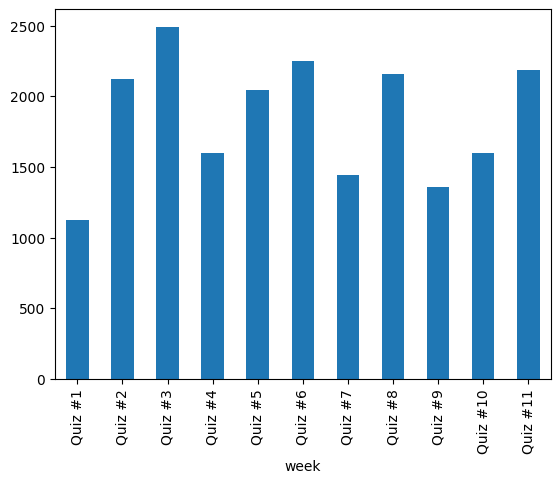

In [8]:
print(df.query("type == 'quizSubmission'")["week"].value_counts()[weeks])
df.query("type == 'quizSubmission'")["week"].value_counts()[weeks].plot(kind='bar')
df["num_attempts"] = df[df['type'] == 'quizSubmission'].groupby(["userId", "exerciseId"])["type"].transform('count')
display(df["num_attempts"] )
plt.savefig('figures/attempts/attemptStarted.png')
plt.show()



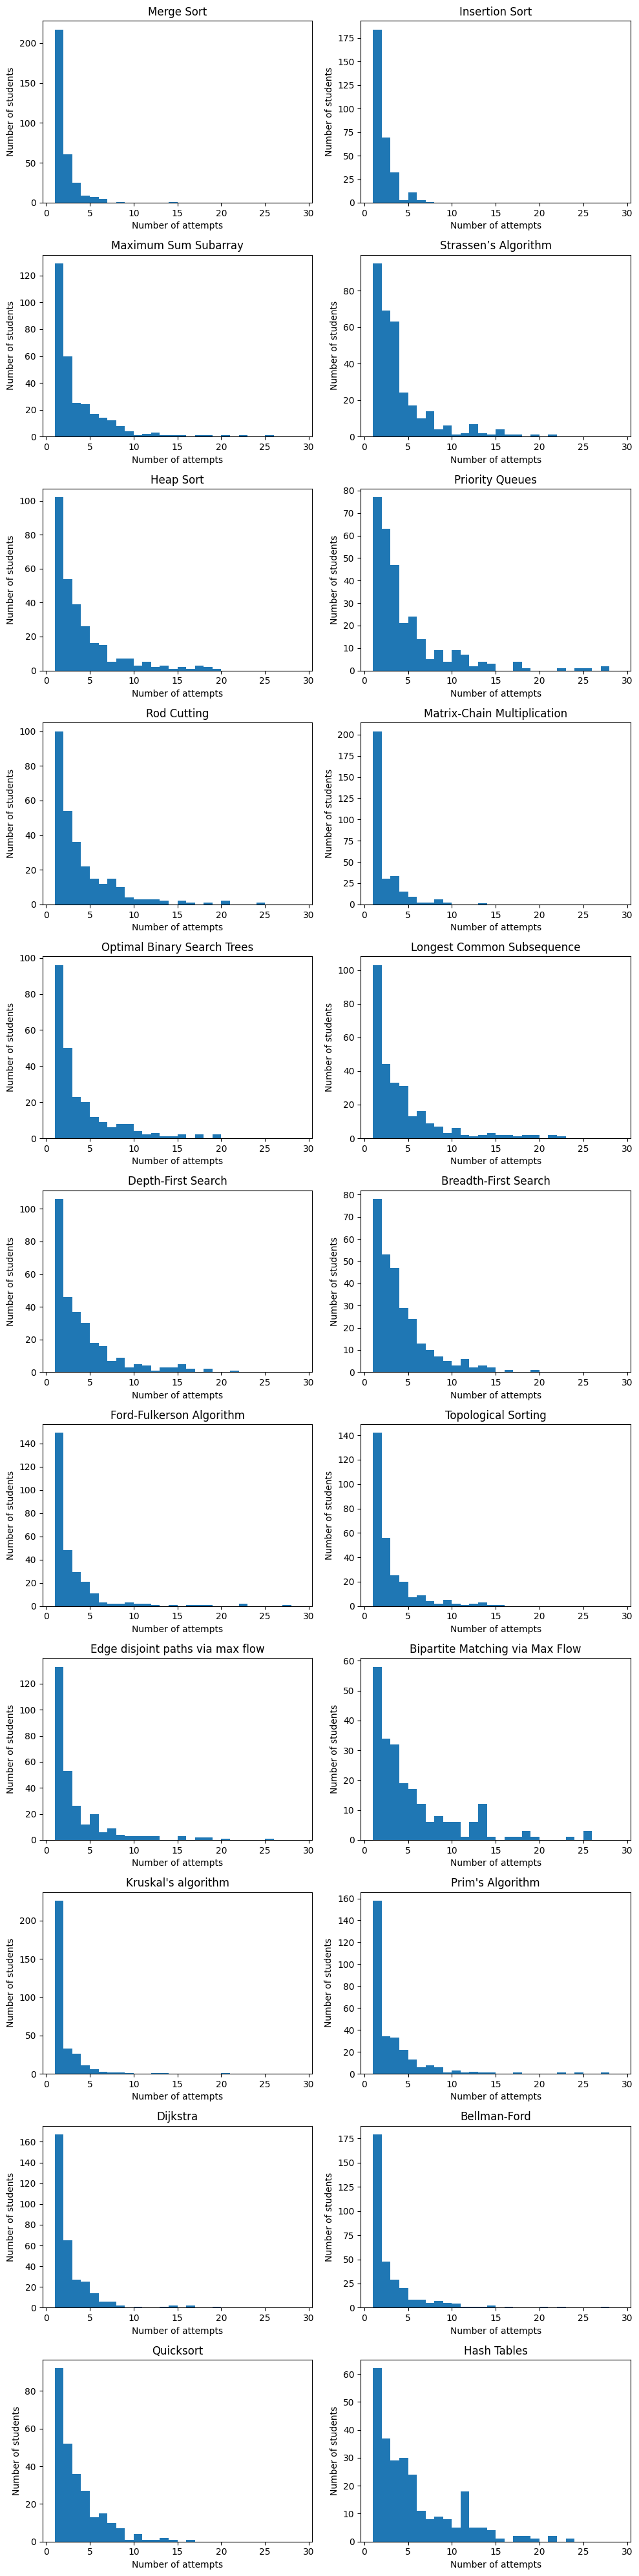

In [9]:
fig, ax = plt.subplots(11, 2, figsize=(10, 40))
bins = np.arange(1, 30,1)
for i,week in enumerate(weeks):
    attempts = df.query("week == @week")
    for j,ex in enumerate(attempts["exerciseName"].unique()):
        q = attempts.query("exerciseName == @ex and type == 'quizSubmission'").drop_duplicates(subset=['userId', 'exerciseId'])["num_attempts"]
        q.plot(kind='hist', bins=bins, ax=ax[i,j])
        ax[i,j].set_xlabel("Number of attempts")
        ax[i,j].set_ylabel("Number of students")
        ax[i,j].set_title(ex)

plt.tight_layout()
plt.savefig('figures/attempts/number_of_attempts.png')
plt.show()

## Number of Attempts

3.1610305958132043 3.185084541062802 0.8055687587601746
9815.0 10549.0


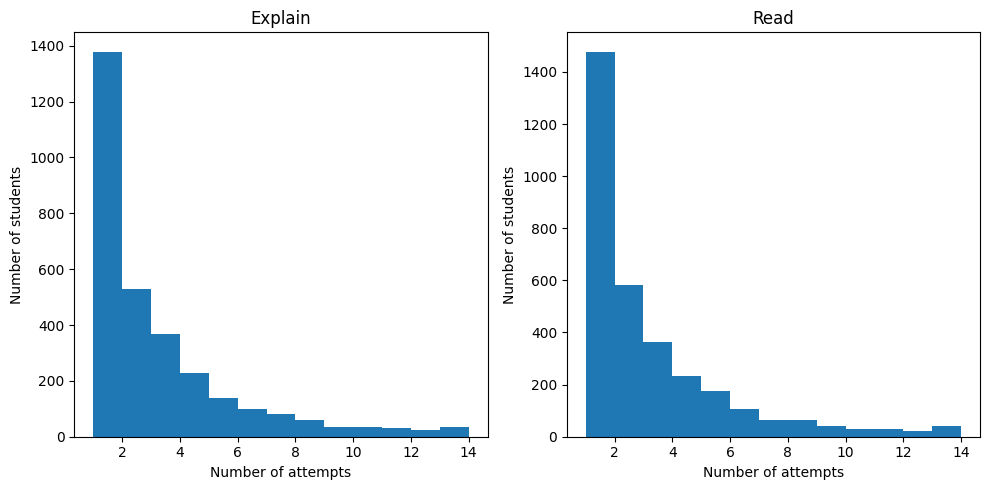

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
bins = np.arange(1, 15,1)
explain = df.query("variant == 'explain'").dropna(subset="num_attempts").drop_duplicates(subset=["userId","exerciseName"])["num_attempts"]
explain.plot(kind='hist', ax=ax[0], title='Explain', bins=bins)
ax[0].set_xlabel("Number of attempts")
ax[0].set_ylabel("Number of students")
ax[0].set_title("Explain")
read = df.query("variant == 'reading'").dropna(subset="num_attempts").drop_duplicates(subset=["userId","exerciseName"])["num_attempts"].dropna()
read.plot(kind='hist', ax=ax[1], title='Read', bins=bins)
ax[1].set_xlabel("Number of attempts")
ax[1].set_ylabel("Number of students")
ax[1].set_title("Read")
plt.tight_layout()
ttest = stats.ttest_ind(explain, read)
print(explain.mean(),read.mean(),ttest.pvalue)
print(explain.sum(),read.sum())


Merge Sort: Explain mean: 2.28, Reading mean: 1.54, p-value: 0.13
Insertion Sort: Explain mean: 1.62, Reading mean: 1.74, p-value: 0.33
Strassen’s Algorithm: Explain mean: 3.66, Reading mean: 3.40, p-value: 0.49
Maximum Sum Subarray: Explain mean: 3.01, Reading mean: 3.41, p-value: 0.31
Priority Queues: Explain mean: 3.95, Reading mean: 5.52, p-value: 0.03
Heap Sort: Explain mean: 4.01, Reading mean: 3.28, p-value: 0.08
Rod Cutting: Explain mean: 3.75, Reading mean: 3.42, p-value: 0.44
Matrix-Chain Multiplication: Explain mean: 1.83, Reading mean: 1.93, p-value: 0.62
Optimal Binary Search Trees: Explain mean: 3.21, Reading mean: 3.70, p-value: 0.27
Longest Common Subsequence: Explain mean: 3.74, Reading mean: 4.50, p-value: 0.22
Breadth-First Search: Explain mean: 4.29, Reading mean: 3.31, p-value: 0.04
Depth-First Search: Explain mean: 3.52, Reading mean: 4.19, p-value: 0.21
Topological Sorting: Explain mean: 2.64, Reading mean: 2.43, p-value: 0.49
Ford-Fulkerson Algorithm: Explain me

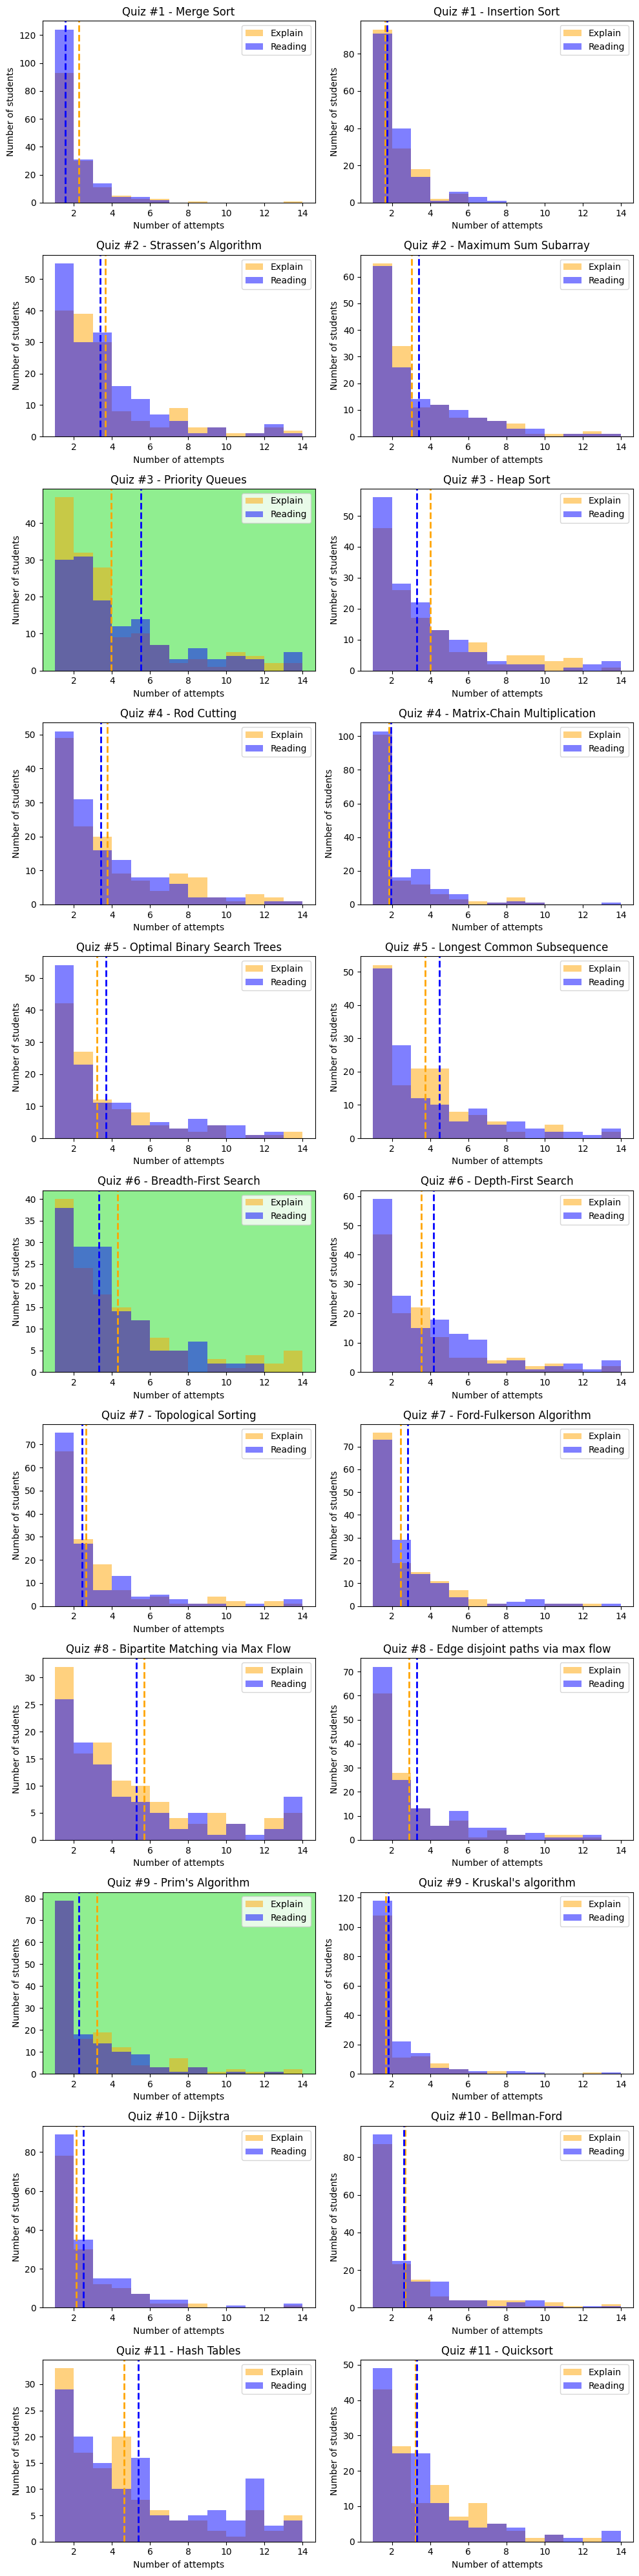

In [11]:
fig, ax = plt.subplots(len(weeks), 2, figsize=(10, 40))
bins = np.arange(1, 15, 1)

for week in weeks:
    explain = df.query("variant == 'explain' and week == @week").dropna(subset="num_attempts").drop_duplicates(subset=['userId', 'exerciseId'])
    read = df.query("variant == 'reading' and week == @week").dropna(subset="num_attempts").drop_duplicates(subset=['userId', 'exerciseId'])
    exercise_list = list(explain["exerciseName"].unique())

    for ex in exercise_list:
        idx = exercise_list.index(ex)          
        dfe = explain.query("exerciseName == @ex")["num_attempts"]
        dfr = read.query("exerciseName == @ex")["num_attempts"]        
        dfe.plot(kind='hist', ax=ax[weeks.index(week), idx], bins=bins, alpha=0.5, label='Explain', color='orange')
        dfr.plot(kind='hist', ax=ax[weeks.index(week), idx], bins=bins, alpha=0.5, label='Reading', color='blue')
        ax[weeks.index(week), idx].set_xlabel("Number of attempts")
        ax[weeks.index(week), idx].set_ylabel("Number of students")
        ax[weeks.index(week), idx].set_title(f"{week} - {ex}")        
        ax[weeks.index(week), idx].axvline(dfe.mean(), color='orange', linestyle='dashed', linewidth=2)
        ax[weeks.index(week), idx].axvline(dfr.mean(), color='blue', linestyle='dashed', linewidth=2)
        ttest = stats.ttest_ind(dfe, dfr)        
        if ttest.pvalue < 0.05:
            ax[weeks.index(week), idx].set_facecolor('lightgreen')        
        print(f"{ex}: Explain mean: {dfe.mean():.2f}, Reading mean: {dfr.mean():.2f}, p-value: {ttest.pvalue:.2f}")
        ax[weeks.index(week), idx].legend()

plt.tight_layout()


## Number of Completed Exercises

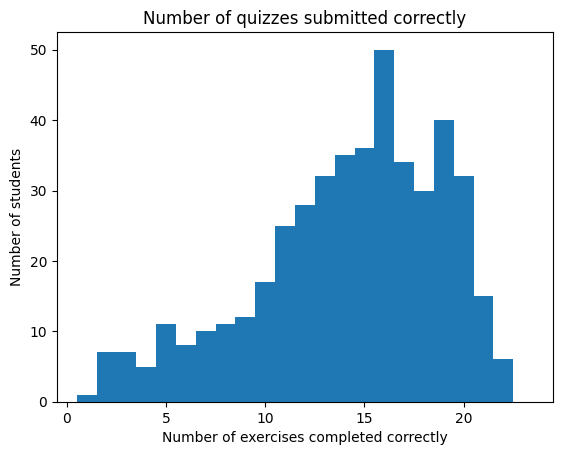

In [12]:
df[(df["type"]=="quizSubmission") & (df["details"].apply(
    lambda x: x.get("correctness")==1 if x is not None else False))]["userId"].value_counts().plot(
        kind='hist', bins=np.arange(1,25, 1))
plt.xticks(np.arange(1,25,5)-0.5, np.arange(0,25,5))
plt.xlabel("Number of exercises completed correctly")
plt.ylabel("Number of students")
plt.title("Number of quizzes submitted correctly")
plt.xlim(0,25)
plt.savefig('figures/attempts/number_of_quizzes.png')
plt.show()


# Quiz Time Analysis

count    6417.000000
mean        8.034956
std         8.457135
min         0.083342
25%         2.480682
50%         5.091302
75%        10.351065
max        54.753155
Name: timeSpent_quiz, dtype: float64


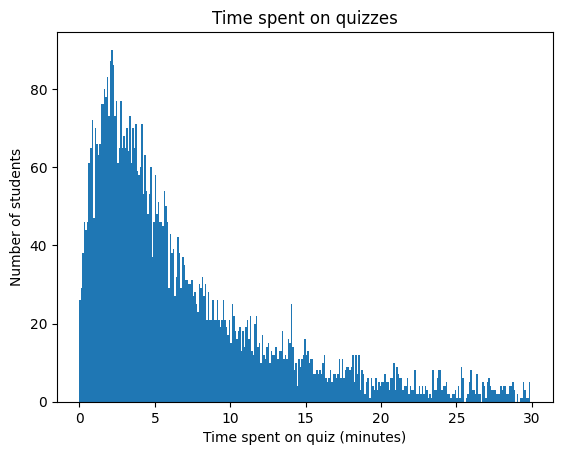

In [13]:
ts_df =df.drop_duplicates(subset=["userId", "exerciseName"])
ts = ts_df["timeSpent_quiz"]
print(ts.describe())
ts.plot(kind='hist', bins=np.arange(0, 30, .1))
plt.xlabel("Time spent on quiz (minutes)")
plt.ylabel("Number of students")
plt.title("Time spent on quizzes")
plt.savefig('figures/quiz/time_spent.png')
plt.show()


## Explain vs Read

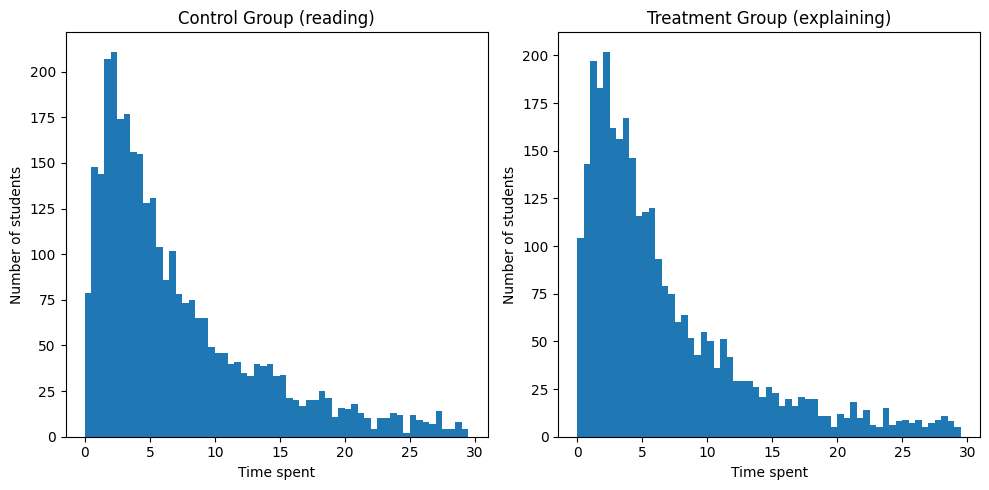

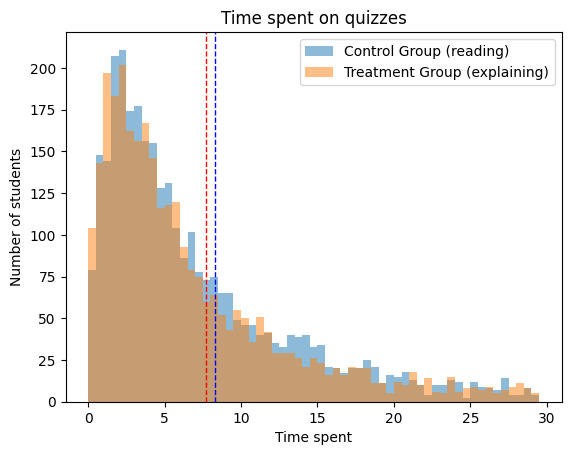

Reading group: 8.321457311608725
Explaining group: 7.729354725415813
TtestResult(statistic=np.float64(2.8081609847741813), pvalue=np.float64(0.004997595201368695), df=np.float64(6412.102411310219))


In [14]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
reading = df[df["variant"] == "reading"].drop_duplicates(subset=["userId", "exerciseName"])
explaining = df[df["variant"] == "explain"].drop_duplicates(subset=["userId", "exerciseName"])
bins = np.arange(0, 30, 0.5)
reading["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[0])
explaining["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[1])
axs[0].set_title("Control Group (reading)")
axs[1].set_title("Treatment Group (explaining)")
axs[0].set_xlabel("Time spent")
axs[1].set_xlabel("Time spent")
axs[0].set_ylabel("Number of students")
axs[1].set_ylabel("Number of students")
#plot averages
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups.png')
plt.show()
# plot on the same graph
bins = np.arange(0, 30, 0.5)
reading["timeSpent_quiz"].plot(kind="hist", bins=bins, alpha=0.5, label="Control Group (reading)")
explaining["timeSpent_quiz"].plot(kind="hist", bins=bins, alpha=0.5, label="Treatment Group (explaining)")
#plot averages
plt.axvline(reading["timeSpent_quiz"].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(explaining["timeSpent_quiz"].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Time spent")
plt.ylabel("Number of students")
plt.title("Time spent on quizzes")
plt.legend()
plt.savefig('figures/quiz/time_spent_groups_overlay.png')
plt.show()
print("Reading group:", reading["timeSpent_quiz"].mean())
print("Explaining group:", explaining["timeSpent_quiz"].mean())
print(stats.ttest_ind(reading["timeSpent_quiz"],explaining["timeSpent_quiz"],equal_var=False))

## A vs B (Overall)

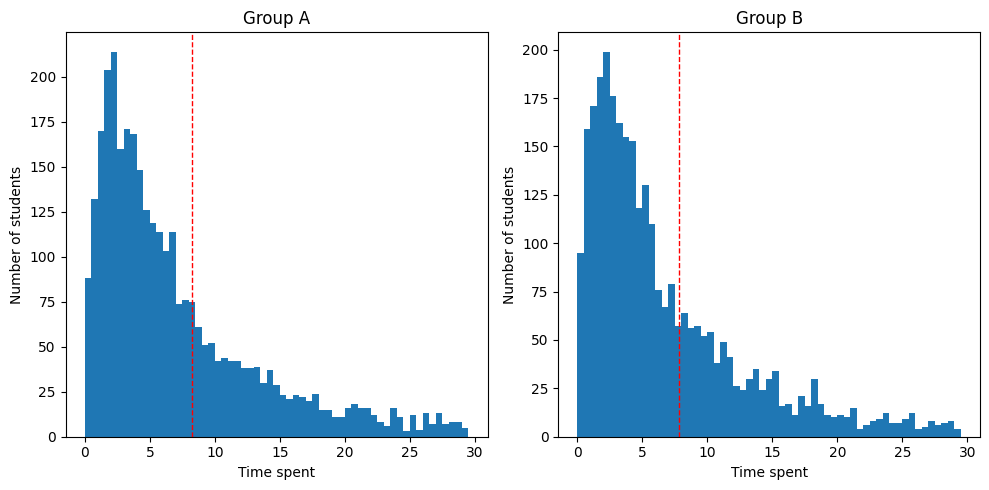

Group A: 8.250786370779105
Group B: 7.805454183375466
TtestResult(statistic=np.float64(2.1107138899180793), pvalue=np.float64(0.034835542803308216), df=np.float64(6409.279747300137))


In [15]:
group_A = ts_df.query(" userGroup== 'A'")["timeSpent_quiz"]
group_B = ts_df.query(" userGroup== 'B'")["timeSpent_quiz"]
fig, axs = plt.subplots(1,2, figsize=(10, 5))
group_A.plot(kind="hist", bins=bins, ax=axs[0])
group_B.plot(kind="hist", bins=bins, ax=axs[1])
axs[0].set_title("Group A")
axs[1].set_title("Group B")
axs[0].set_xlabel("Time spent")
axs[1].set_xlabel("Time spent")
axs[0].set_ylabel("Number of students")
axs[1].set_ylabel("Number of students")
#plot averages
axs[0].axvline(group_A.mean(), color='r', linestyle='dashed', linewidth=1)
axs[1].axvline(group_B.mean(), color='r', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups.png')
plt.show()
print("Group A:", group_A.mean())
print("Group B:", group_B.mean())
print(stats.ttest_ind(group_A,group_B,equal_var=False))




## Explain vs Read (By Quiz)

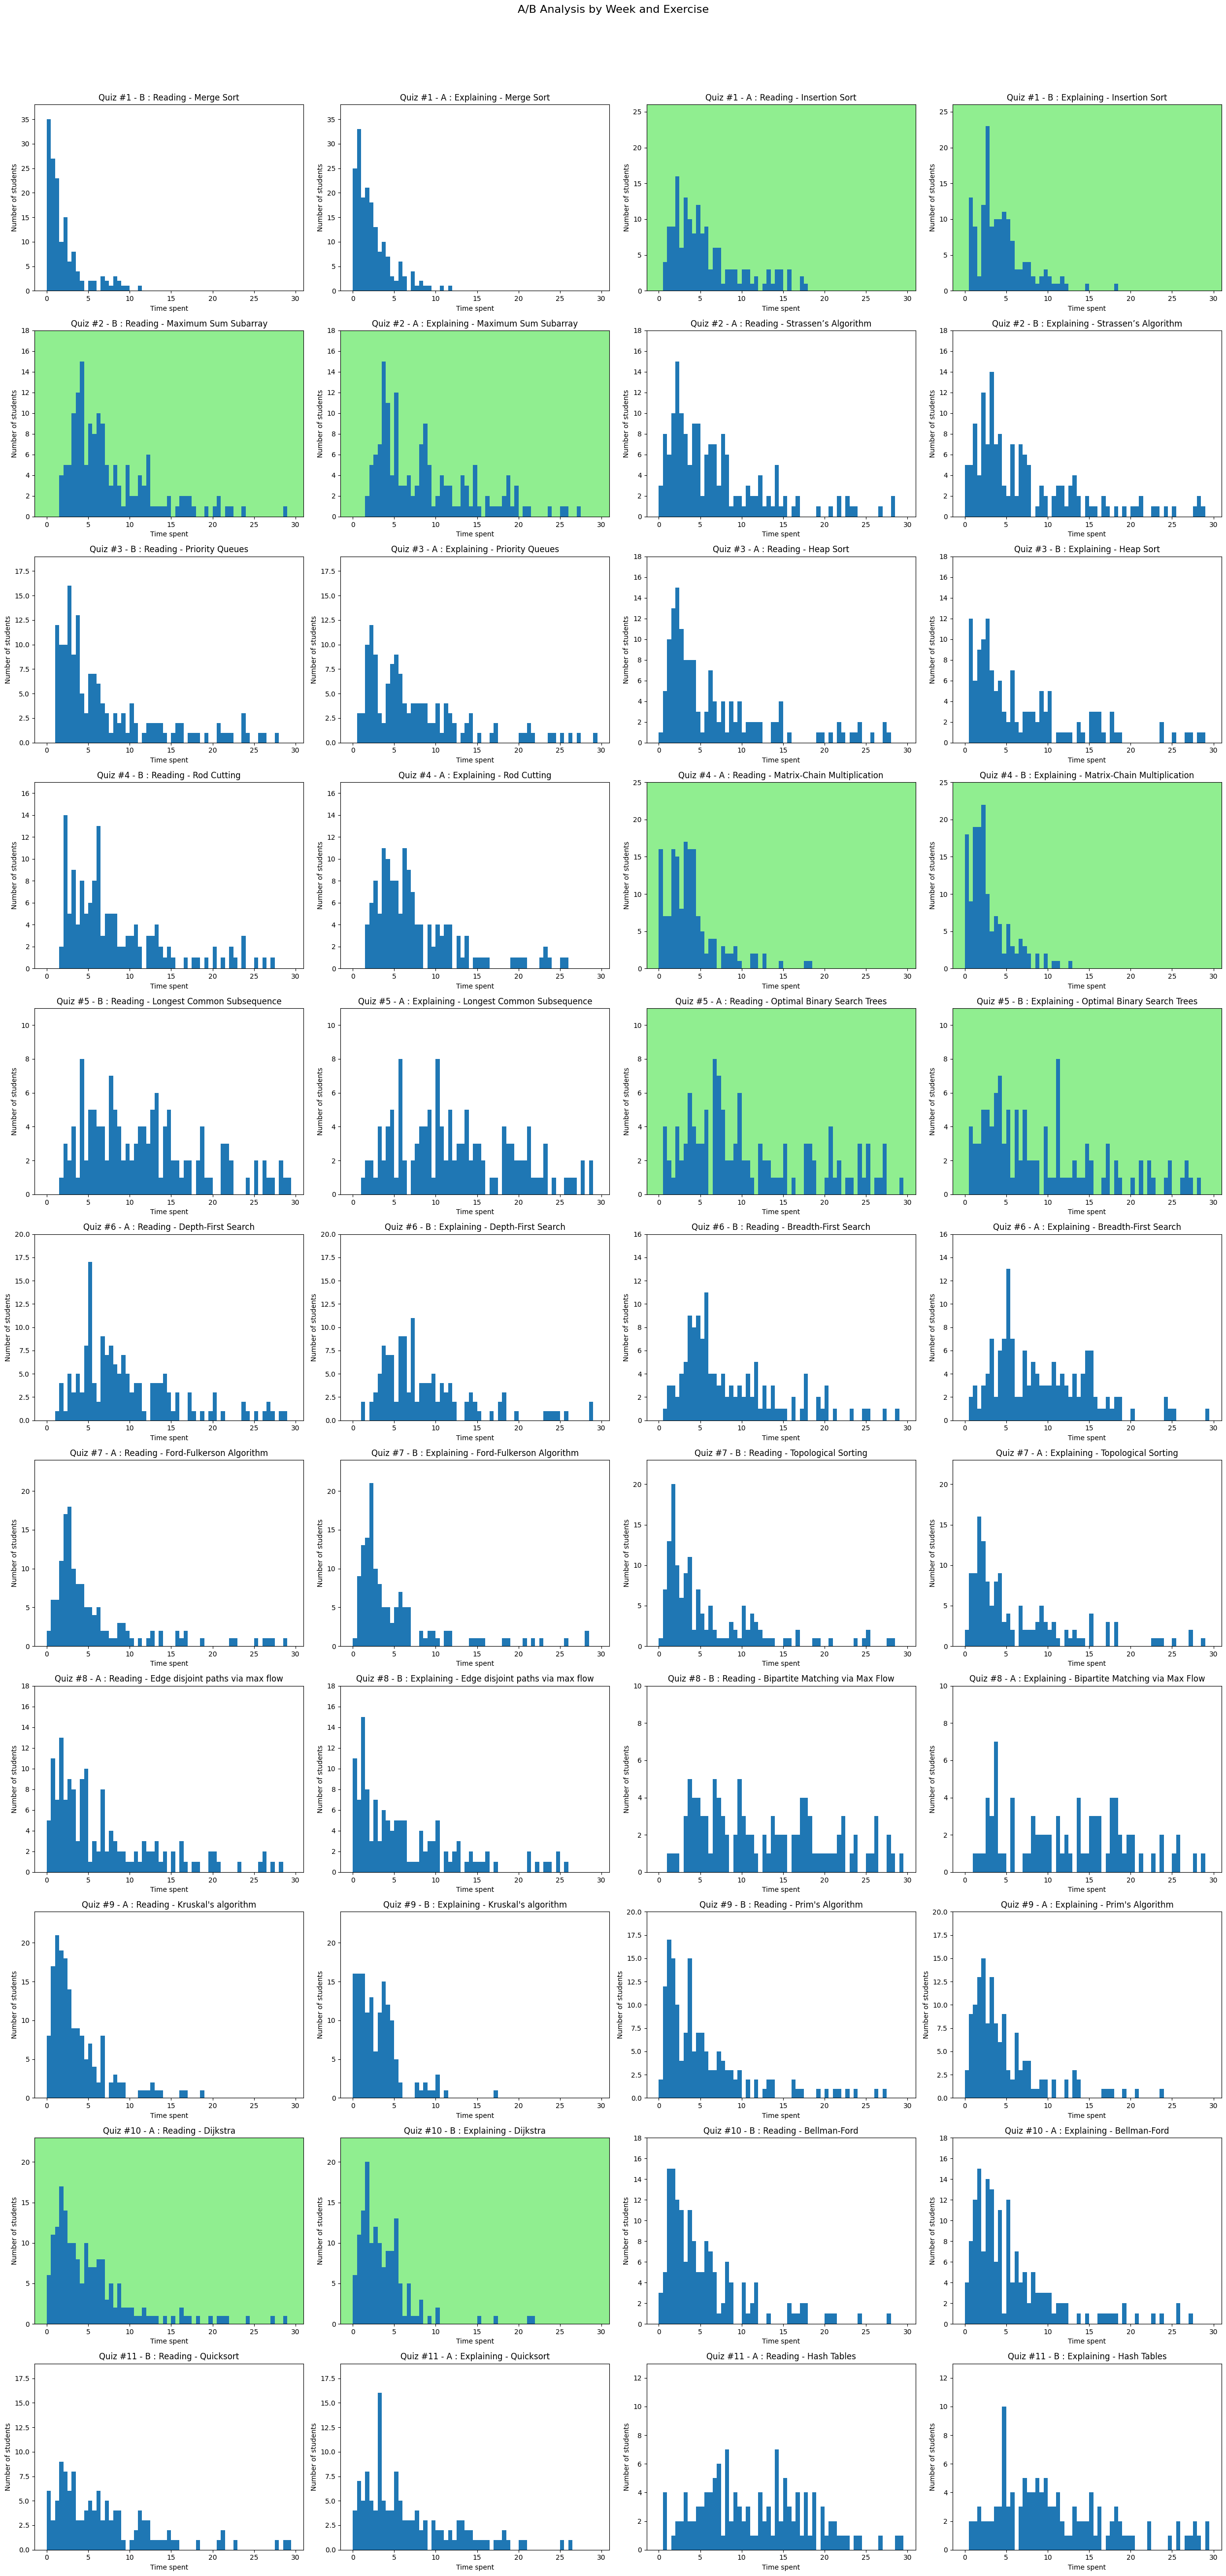

Quiz #1 - Merge Sort - Pvalue : 0.22563665886021936
----------------------------------------
Quiz #1 - Insertion Sort - Pvalue : 0.001801902559403414
A
count    156.000000
mean       5.741343
std        4.094738
min        0.571815
25%        2.568726
50%        4.583274
75%        7.270902
max       17.564672
Name: timeSpent_quiz, dtype: float64
--------------------
B
count    147.000000
mean       4.444917
std        3.014578
min        0.603538
25%        2.528048
50%        3.835809
75%        5.681599
max       18.340418
Name: timeSpent_quiz, dtype: float64
----------------------------------------
Quiz #2 - Maximum Sum Subarray - Pvalue : 0.02253198489402421
A
count    154.000000
mean       7.944114
std        5.591200
min        1.771639
25%        4.007770
50%        6.290585
75%       10.274851
max       34.695911
Name: timeSpent_quiz, dtype: float64
--------------------
B
count    153.000000
mean       9.633962
std        7.210163
min        1.696536
25%        4.201853
50%   

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Initialize a figure with specified size
fig, axs = plt.subplots(11, 4, figsize=(25, 55))  # 11 rows, 4 columns
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing

stats_arr = []
# Flatten the axes array for easy indexing
axs = axs.flatten()

plot_index = 0  # To track the subplot index
for week in weeks:
    group_a = df[(df["userGroup"] == "A") & (df["week"] == week)].drop_duplicates(subset=["userId", "exerciseName"]).dropna(subset=["timeSpent_quiz"])
    group_b = df[(df["userGroup"] == "B") & (df["week"] == week)].drop_duplicates(subset=["userId", "exerciseName"]).dropna(subset=["timeSpent_quiz"])
    exercise_list = group_a["exerciseName"].unique()
    
    for exo in exercise_list:
        bins = np.arange(0, 30, 0.5)
        cg = group_a[group_a["exerciseName"] == exo]["controlGroup"].values[0]
        
        if cg == "A":
            index = 0
            axs[plot_index].set_title(f"{week} - A : Reading - {exo}")
            axs[plot_index + 1].set_title(f"{week} - B : Explaining - {exo}")
        else:
            index = 1
            axs[plot_index + 1].set_title(f"{week} - A : Explaining - {exo}")
            axs[plot_index].set_title(f"{week} - B : Reading - {exo}")
        
        # Plot histograms for both groups
        group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[plot_index])
        group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[plot_index + 1])
        
        # Set axis labels
        axs[plot_index].set_xlabel("Time spent")
        axs[plot_index + 1].set_xlabel("Time spent")
        axs[plot_index].set_ylabel("Number of students")
        axs[plot_index + 1].set_ylabel("Number of students")

        # Set constant y-axis for comparison
        max_occ1 = pd.cut(group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"], bins=bins).value_counts().max()
        max_occ2 = pd.cut(group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"], bins=bins).value_counts().max()
        max_occ = max(max_occ1, max_occ2)+3
        axs[plot_index].set_ylim([0, max_occ])
        axs[plot_index + 1].set_ylim([0, max_occ])
        
        # Perform t-test
        ttest = stats.ttest_ind(group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"], group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"], equal_var=False)
        stats_arr.append(f"{week} - {exo} - Pvalue : {ttest.pvalue}")
        
        if ttest.pvalue < 0.05:
            axs[plot_index].set_facecolor('lightgreen')
            axs[plot_index + 1].set_facecolor('lightgreen')
            s = "A\n" + str(group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"].describe()) + "\n" + "-"*20 + "\n"
            s += "B\n" + str(group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"].describe())
            stats_arr.append(s)
        
        stats_arr.append("-"*40)
        plot_index += 2  # Move to the next pair of subplots
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("A/B Analysis by Week and Exercise", fontsize=16)
plt.savefig('figures/quiz/time_spent_groups_week.png')
plt.show()


# Print stats
for line in stats_arr:
    print(line)

# Message Time Analysis

## Number of Messages

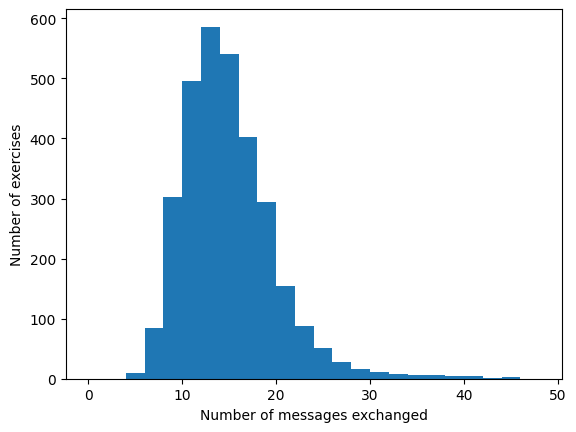

count    3097.000000
mean       14.960284
std         5.037460
min         5.000000
25%        11.000000
50%        15.000000
75%        17.000000
max        49.000000
Name: n_mess, dtype: float64


In [17]:
mess_df = df.drop_duplicates(subset=["userId","exerciseId"]).query("n_mess <50")
mess_df["n_mess"].plot(kind='hist', bins=np.arange(0, 50, 2))
plt.xlabel("Number of messages exchanged")
plt.ylabel("Number of exercises")
plt.savefig('figures/messages/n_mess.png')
plt.show() 
print(mess_df["n_mess"].describe())


### A vs B (Overall)

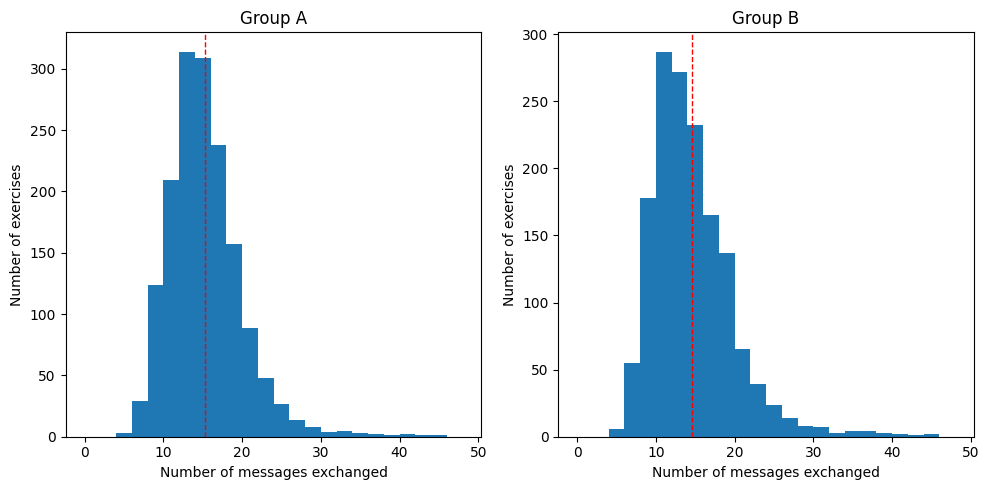

Group A: 15.297229219143578
Group B: 14.60569913850232
TtestResult(statistic=np.float64(3.8154895876612787), pvalue=np.float64(0.0001386459322034252), df=np.float64(3009.77215380594))


In [18]:
group_A = mess_df.query(" userGroup== 'A'")["n_mess"]
group_B = mess_df.query(" userGroup== 'B'")["n_mess"]
fig, axs = plt.subplots(1,2, figsize=(10, 5))
group_A.plot(kind="hist", bins=np.arange(0,50, 2), ax=axs[0])
group_B.plot(kind="hist", bins=np.arange(0,50, 2), ax=axs[1])
axs[0].set_title("Group A")
axs[1].set_title("Group B")
axs[0].set_xlabel("Number of messages exchanged")
axs[1].set_xlabel("Number of messages exchanged")
axs[0].set_ylabel("Number of exercises")
axs[1].set_ylabel("Number of exercises")
#plot averages
axs[0].axvline(group_A.mean(), color='r', linestyle='dashed', linewidth=1)
axs[1].axvline(group_B.mean(), color='r', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.savefig('figures/messages/n_mess_groups.png')
plt.show()
print("Group A:", group_A.mean())
print("Group B:", group_B.mean())
print(stats.ttest_ind(group_A,group_B,equal_var=False))


### A vs B (By Week)

Quiz #1 - Pvalue : 0.20936251501217482
----------------------------------------
Quiz #2 - Pvalue : 1.682321806124798e-13
Group A
14.214285714285714
Group B
11.503311258278146
----------------------------------------
Quiz #3 - Pvalue : 8.304217671932954e-16
Group A
15.929936305732484
Group B
11.619718309859154
----------------------------------------
Quiz #4 - Pvalue : 0.1782704517285392
----------------------------------------
Quiz #5 - Pvalue : 0.10312212940638893
----------------------------------------
Quiz #6 - Pvalue : 0.7836454411690739
----------------------------------------
Quiz #7 - Pvalue : 0.004381319393651291
Group A
14.757142857142858
Group B
16.41176470588235
----------------------------------------
Quiz #8 - Pvalue : 0.640771787558569
----------------------------------------
Quiz #9 - Pvalue : 0.5554277983775182
----------------------------------------
Quiz #10 - Pvalue : 0.005346862796793842
Group A
14.314102564102564
Group B
16.01388888888889
-------------------------

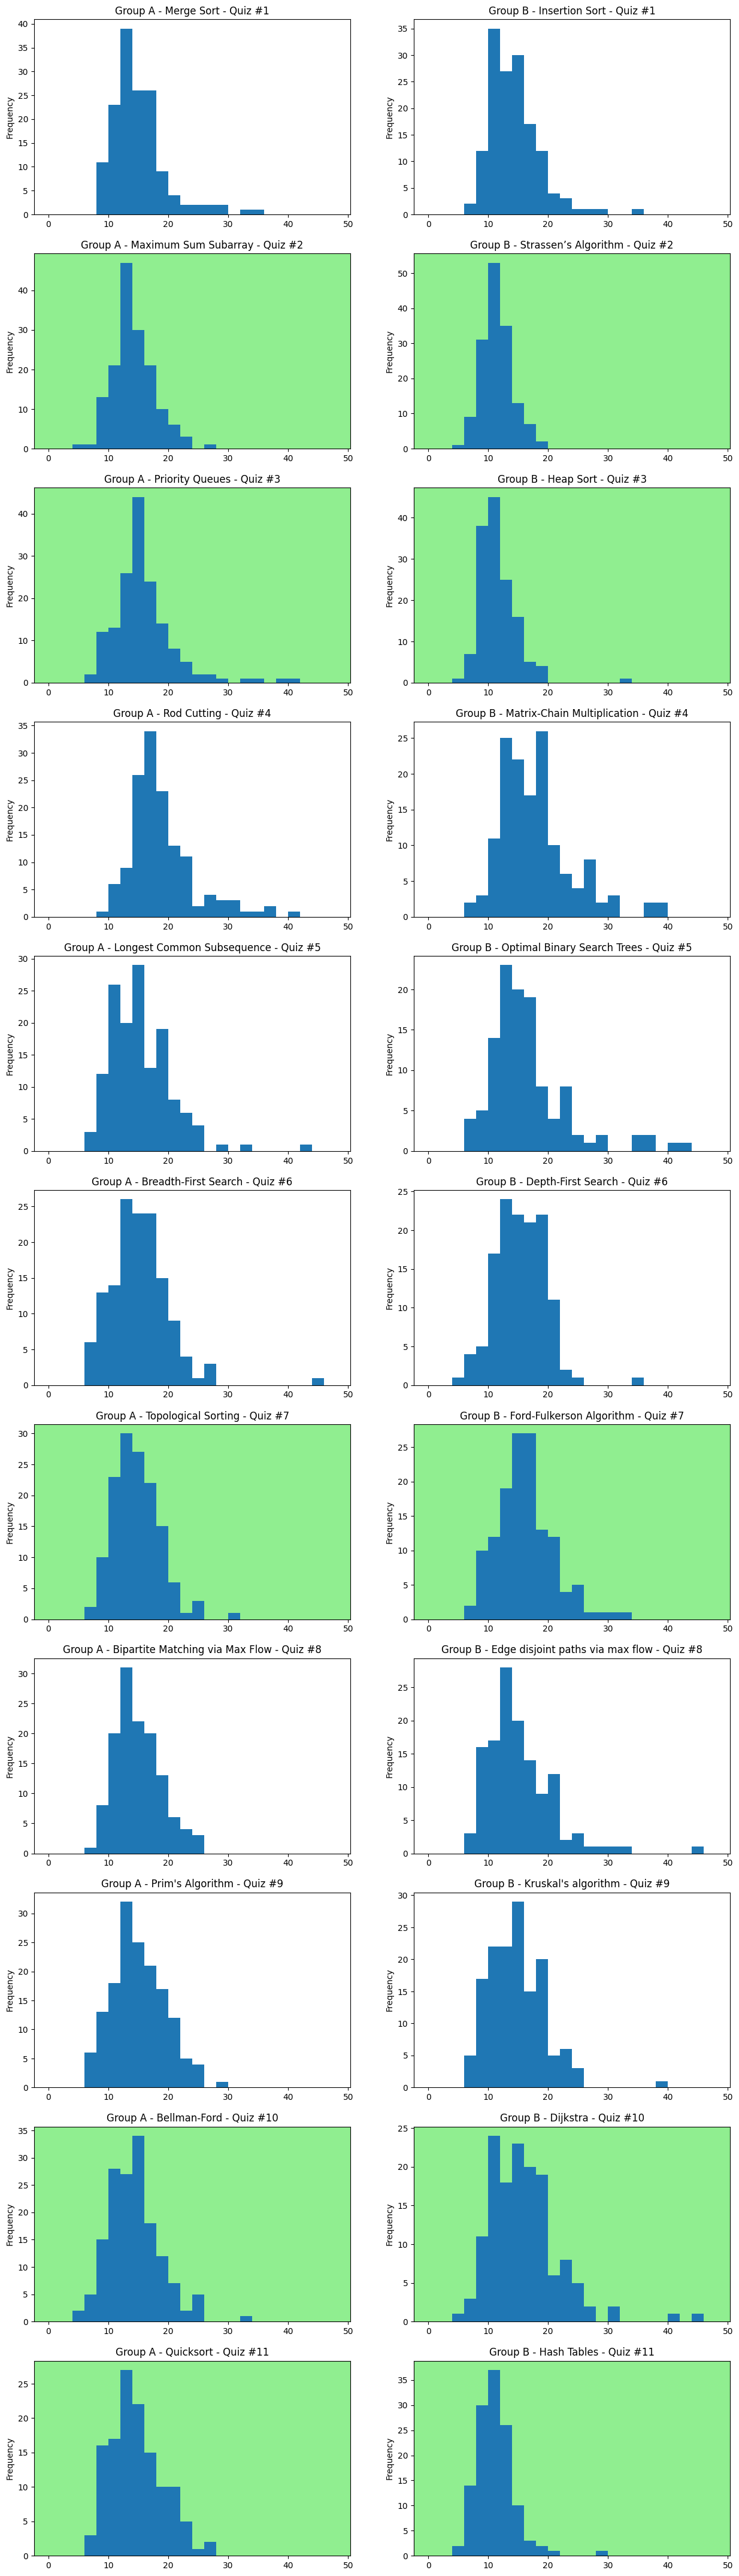

In [19]:
#number of message per week
fig, axs = plt.subplots(len(weeks),2, figsize=(15, 55))
for i,week in enumerate(weeks):
    group_a = mess_df[(mess_df["userGroup"] == "A") & (mess_df["week"] == week)]
    group_b = mess_df[(mess_df["userGroup"] == "B") & (mess_df["week"] == week)]
    bins = np.arange(0, 50, 2)
    group_a["n_mess"].plot(kind="hist", bins=bins, ax=axs[i,0])
    group_b["n_mess"].plot(kind="hist", bins=bins, ax=axs[i,1])
    axs[i,0].set_title("Group A - "+group_a["exerciseName"].values[0]+" - "+week)
    axs[i,1].set_title("Group B - "+group_b["exerciseName"].values[0]+" - "+week)
    # plt.suptitle(week)    
    ttest = stats.ttest_ind(group_a["n_mess"], group_b["n_mess"], equal_var=False)
    print(f"{week} - Pvalue : {ttest.pvalue}")
    if ttest.pvalue < 0.05:
        print("Group A")
        print(group_a["n_mess"].mean())
        print("Group B")
        print(group_b["n_mess"].mean())
        axs[i,0].set_facecolor('lightgreen')
        axs[i,1].set_facecolor('lightgreen')
        # # show mean
        # axs[i,0].axvline(group_a["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
        # axs[i,1].axvline(group_b["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
    print("-"*40)
plt.savefig('figures/messages/n_mess_groups_week.png')
plt.show()


## Time Spent on Messages

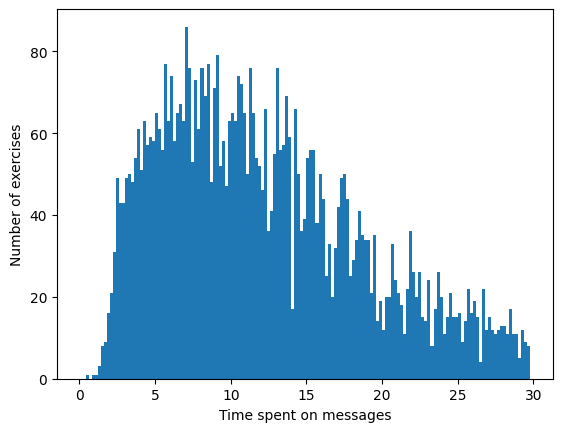

count    6397.000000
mean      100.071162
std       600.775280
min         0.551819
25%         7.487632
50%        12.628596
75%        20.653500
max      9967.245606
Name: timeSpent_message, dtype: float64


In [20]:

tsm = df.drop_duplicates(subset=["userId","exerciseId"])
tsm["timeSpent_message"].plot(kind='hist', bins=np.arange(0, 30, .20))
plt.xlabel("Time spent on messages")
plt.ylabel("Number of exercises")
plt.savefig('figures/messages/time_spent.png')
plt.show()
print(tsm["timeSpent_message"].describe())


### A vs B (Overall)

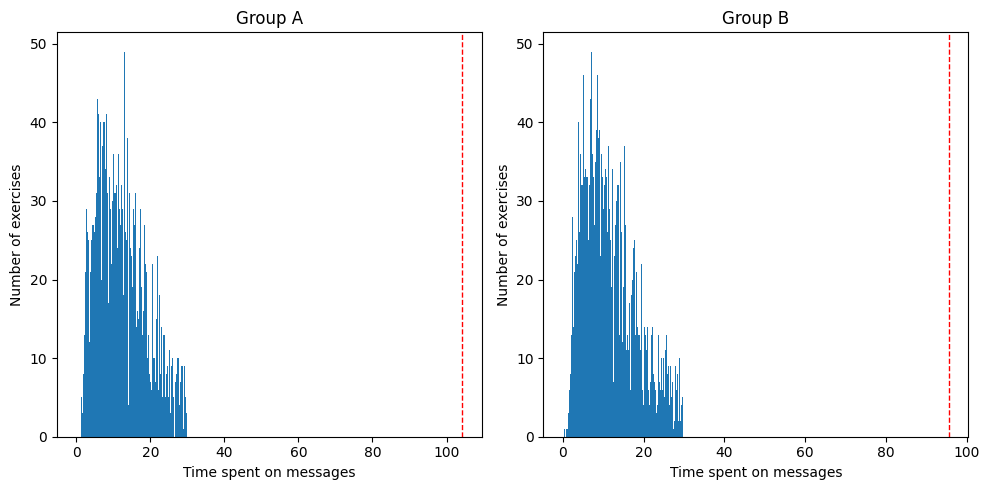

Group A: 104.25290578636273
Group B: 95.62923880532956
TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))


In [21]:
group_A = tsm.query("userGroup == 'A'")
group_B = tsm.query("userGroup == 'B'")
fig, axs = plt.subplots(1,2, figsize=(10, 5))
group_A["timeSpent_message"].plot(kind="hist", bins=np.arange(0,30, .2), ax=axs[0])
group_B["timeSpent_message"].plot(kind="hist", bins=np.arange(0,30, .2), ax=axs[1])
axs[0].set_title("Group A")
axs[1].set_title("Group B")
axs[0].set_xlabel("Time spent on messages")
axs[1].set_xlabel("Time spent on messages")
axs[0].set_ylabel("Number of exercises")
axs[1].set_ylabel("Number of exercises")
#plot averages
axs[0].axvline(group_A["timeSpent_message"].mean(), color='r', linestyle='dashed', linewidth=1)
axs[1].axvline(group_B["timeSpent_message"].mean(), color='r', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.savefig('figures/messages/time_spent_groups.png')
plt.show()
print("Group A:", group_A["timeSpent_message"].mean())
print("Group B:", group_B["timeSpent_message"].mean())
print(stats.ttest_ind(group_A["timeSpent_message"],group_B["timeSpent_message"],equal_var=False))


## A vs B (By Week)

Quiz #1 - Pvalue : 1.3763111179960903e-05
Group A
14.878378378378379
Group B
14.23972602739726
----------------------------------------
Quiz #2 - Pvalue : nan
----------------------------------------
Quiz #3 - Pvalue : nan
----------------------------------------
Quiz #4 - Pvalue : nan
----------------------------------------
Quiz #5 - Pvalue : nan
----------------------------------------
Quiz #6 - Pvalue : nan
----------------------------------------
Quiz #7 - Pvalue : nan
----------------------------------------
Quiz #8 - Pvalue : nan
----------------------------------------
Quiz #9 - Pvalue : nan
----------------------------------------
Quiz #10 - Pvalue : 0.029444129410506552
Group A
14.314102564102564
Group B
16.01388888888889
----------------------------------------
Quiz #11 - Pvalue : nan
----------------------------------------


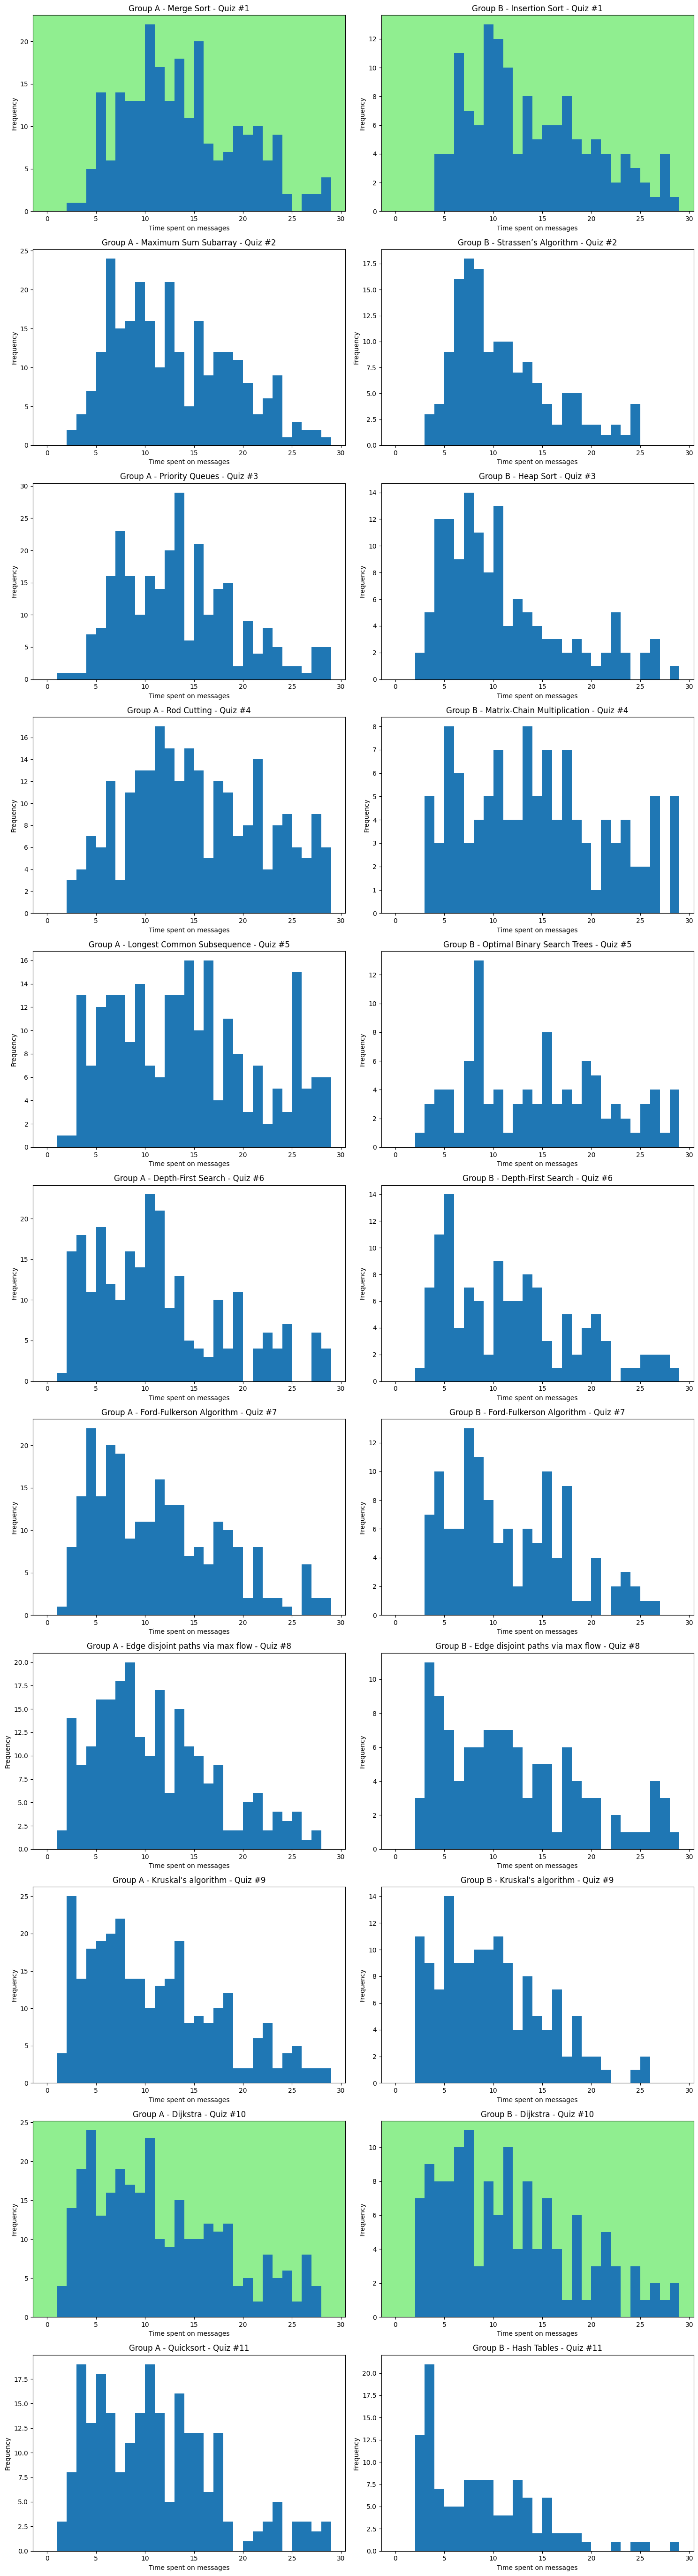

In [22]:
#number of message per week
fig, axs = plt.subplots(len(weeks),2, figsize=(15, 55))
for i,week in enumerate(weeks):
    group_a = tsm[(tsm["userGroup"] == "A") & (tsm["week"] == week)]
    group_b = tsm[(mess_df["userGroup"] == "B") & (tsm["week"] == week)]
    bins = np.arange(0, 30, 1)
    group_a["timeSpent_message"].plot(kind="hist", bins=bins, ax=axs[i,0])
    group_b["timeSpent_message"].plot(kind="hist", bins=bins, ax=axs[i,1])
    axs[i,0].set_title("Group A - "+group_a["exerciseName"].values[0]+" - "+week)
    axs[i,1].set_title("Group B - "+group_b["exerciseName"].values[0]+" - "+week)
    axs[i,0].set_xlabel("Time spent on messages")
    axs[i,1].set_xlabel("Time spent on messages")
    # plt.suptitle(week)    
    ttest = stats.ttest_ind(group_a["timeSpent_message"], group_b["timeSpent_message"], equal_var=False)
    print(f"{week} - Pvalue : {ttest.pvalue}")
    if ttest.pvalue < 0.05:
        print("Group A")
        print(group_a["n_mess"].mean())
        print("Group B")
        print(group_b["n_mess"].mean())
        axs[i,0].set_facecolor('lightgreen')
        axs[i,1].set_facecolor('lightgreen')
        # # show mean
        # axs[i,0].axvline(group_a["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
        # axs[i,1].axvline(group_b["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
    print("-"*40)
plt.savefig('figures/messages/timeSpent_message_groups_week.png')
plt.tight_layout()
plt.show()


# Reading Time Analysis

<Axes: ylabel='Frequency'>

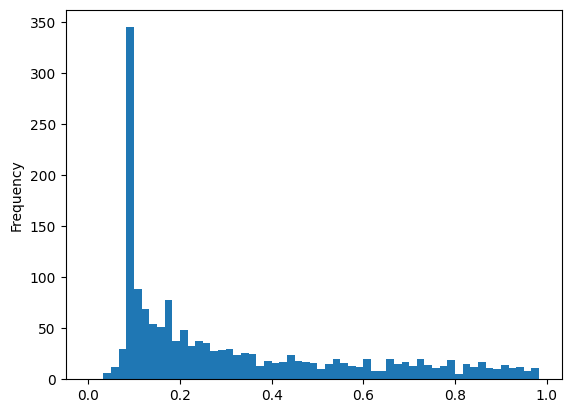

In [23]:
reading = df.query("variant == 'reading'").drop_duplicates(subset=["userId", "exerciseName"])
reading["timeSpent_read"].plot(kind='hist', bins=np.arange(0, 1, 
                                                           1/60))

# Message / Quiz Time Analysis

In [24]:
mq = df.drop_duplicates(subset=["userId","exerciseId"]).query("variant == 'explain'")
mq[["timeSpent_quiz","timeSpent_message"]].describe()

,timeSpent_quiz,timeSpent_message
count,3105.000000,3105.000000
mean,7.729355,14.554318
std,8.261981,9.962099
min,0.083342,2.163939
25%,2.356462,7.328084
50%,4.890300,11.996992
75%,9.945612,18.641197
max,54.282644,56.693464


In [25]:
print(mq[["timeSpent_quiz","timeSpent_message"]].corr())

                   timeSpent_quiz  timeSpent_message
timeSpent_quiz           1.000000           0.056816
timeSpent_message        0.056816           1.000000


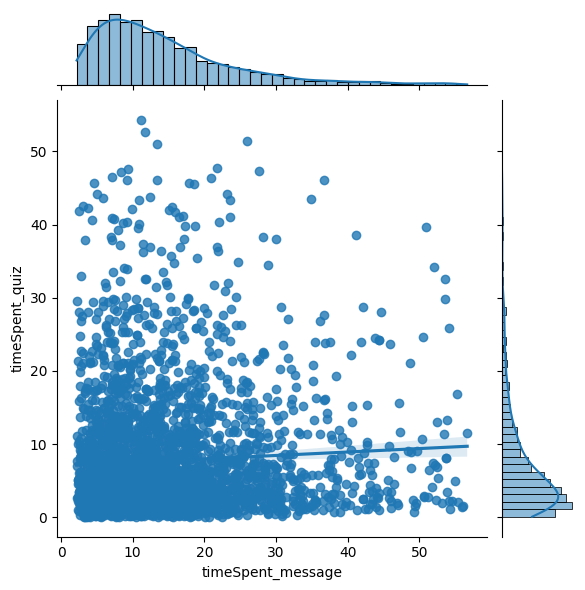

In [26]:
sns.jointplot(data=mq, y="timeSpent_quiz", x="timeSpent_message", kind="reg")

In [27]:
bins = np.arange(0, 35, 5)
mq["bin_avg"] = pd.cut(mq["timeSpent_message"], bins=bins)
display(mq)
display(mq.groupby("bin_avg")["timeSpent_quiz"].mean())

,_creationTime,_id,attemptId,exerciseId,type,userId,variant,details,systemMessageId,userMessageId,...,n_mess,timeSpent_message,userData,userGrades,valid,timeSpent_read,content,content_usr,num_attempts,bin_avg
1,2024-04-16 08:00:01.116,k57000a4rv5wgy13d63pqyt51s6qb2vv,j57adjsev6qjazakv9p4ad7qwh6qany3,k1710bmgh2mwgaqv7sjkmmfh1x6pveqf,quizSubmission,js7ese808vctnr15sy1te2pvx96mndmx,explain,"{'answers': [2.0, 0.0, 2.0], 'correctness': 1....",None,None,...,11.0,16.125910,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 63, 'final': 72, ...",True,2.276635,None,None,9.0,"(15, 20]"
4,2024-03-13 16:35:30.072,k57000mdpmrfm67q4eymvsbqns6n6ezf,j571e3e401tqj2mag6mjgrcynx6n7t96,k1715d99fyvzt35jfm2638g3nd6n35z3,exerciseCompleted,js7534h7gnm8pmyem0n6ttdb816mb94w,explain,None,None,None,...,9.0,3.208412,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 87, 'final': 68, ...",True,1.151624,None,None,NaN,"(0, 5]"
9,2024-04-04 13:43:46.323,k57000x8jdvr4gjsm2p0ey1bms6pj2vt,j57en6wxxqtd4x169vt90y9zdh6pkyh4,k1779x2fet2p0zkazg66nvfcjh6p2vbm,messageSent,js73xpgsqcv0gmv0g1w7as97rd6me4c0,explain,None,jd747sa89e37hf86z054b67wjx6pk19t,jd7b6sqaqbmgvxc1b14sr4rewn6pj0sj,...,17.0,22.485121,"{'gender': 'Male', 'section': 'IN', 'semester'...","{'coding': 85.0, 'midterm': 90, 'final': 79, '...",True,0.831324,Hello! I'm excited to learn about this. Could ...,Hello! I'm here to explain to you how to solve...,NaN,"(20, 25]"
10,2024-04-07 10:08:21.862,k5700154f6etndhepqx0rstrkn6pr0xk,j573anryyjzgxm9rcpdm6t9bys6psp8s,k17asvnfeyp3q949hdkwjq2and6p2x6e,messageSent,js74xtqm1gax5zqzszz0yrnfss6mekyy,explain,None,jd75ge56tp37t39fp4pw04mmcx6ps3s9,jd71yw479qb2cp2xv2k5b7z1n16psack,...,17.0,11.742107,"{'gender': 'Male', 'section': 'IN', 'semester'...","{'coding': 100.0, 'midterm': 47, 'final': 69, ...",True,0.667073,"I see, so we calculate the cost for each possi...",To calculate the cost of multiplying a subchai...,NaN,"(10, 15]"
12,2024-04-22 09:28:34.208,k570015f8vcye8mbv9tb6w8hv96qpwq6,j57e15s47pzdb00vn5057zr6md6qq4aq,k17aatn2xs5xgqg6cgcjm1tqcn6q0cw7,messageSent,js71v2af0tfkjx57xy21wqhyyx6md2et,explain,None,jd71n1g8c1pd1vb0vgq841h0356qp18w,jd7dvv02ctfyw1p9ns9bd635j16qpydg,...,11.0,4.240731,"{'gender': 'Male', 'section': 'IN', 'semester'...","{'coding': 100.0, 'midterm': 72, 'final': 51, ...",True,4.964135,You have understood the Depth-First Search (DF...,"Yes, you're correct. In scenarios where there ...",NaN,"(0, 5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41564,2024-03-03 17:57:34.920,k574cbhc14qpds5vvgbzzwhar16mja7g,j57193v69gwd5d96kw0rfc9s6h6mkx40,k17dh8h1cdvfn45j3527z3w2d96m8zk6,feedbackGiven,js73zd9ts5drk3bf0qxqhb32a96me9y6,explain,None,jd7c8vm606p3c28vk3e21j4mtd6mkyay,None,...,11.0,28.041080,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 54, 'final': 68, ...",True,1.529311,You have explained the Merge Sort algorithm co...,None,NaN,"(25, 30]"
43341,2024-05-20 10:28:16.649,k574j96b0m3y9rdy7hhtjpy64d6se7mk,j5732za9bc5znn2cfrx8t043h16sf2hz,k176kkt806khrpxnctb9hczm316rtsrq,messageSent,js74pf2m8e8jrz2gg9s1hep35s6mfngw,explain,None,jd7bytbw10r467t0zsn760ptmd6sf7bp,jd775da7bgg5tkms5q9nsf59696sfsh5,...,11.0,2.586922,"{'gender': 'Female', 'section': 'SC_DS', 'seme...","{'coding': 100.0, 'midterm': 81, 'final': 52, ...",True,0.167163,"Okay, got it. Now, when does the algorithm kno...",t simply skips that node and moves on to the n...,NaN,"(0, 5]"
48423,2024-03-03 13:14:30.634,k57531qmyef238nwft2sbqxyc16mkvdk,j57dfp1wann33m1kwv4bg0v2xs6mj32b,k17dh8h1cdvfn45j3527z3w2d96m8zk6,answerGenerated,js749jccx4w28s4kqv3rnahw6x6meyf2,explain,None,jd7cnak40y9med1kwkr9s6w3f16mk7b7,jd74s64czt61cp7emhyhz4ke0n6mj4pk,...,13.0,23.820476,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 85.0, 'midterm': 60, 'final': 66, '...",True,3572.112379,I see. So the merging process works by compari...,Taking back my example from the dividing phase...,

bin_avg
(0, 5]      6.946558
(5, 10]     7.570513
(10, 15]    7.334612
(15, 20]    8.243115
(20, 25]    8.356078
(25, 30]    8.139037
Name: timeSpent_quiz, dtype: float64

## Grade Analysis

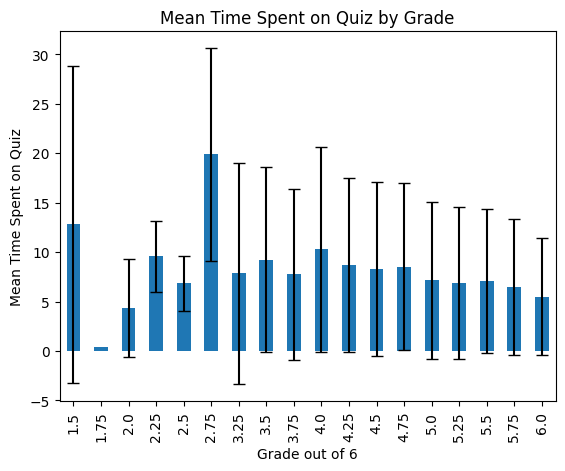

In [28]:
# Calculate mean and standard deviation
mean_time_spent = mq.groupby(mq["userGrades"].dropna().apply(lambda x: x.get("grade_out_of_6")))["timeSpent_quiz"].mean()
std_time_spent = mq.groupby(mq["userGrades"].dropna().apply(lambda x: x.get("grade_out_of_6")))["timeSpent_quiz"].std()

# Plot with error bars
mean_time_spent.plot(kind='bar', yerr=std_time_spent, capsize=4)
plt.xlabel('Grade out of 6')
plt.ylabel('Mean Time Spent on Quiz')
plt.title('Mean Time Spent on Quiz by Grade')
plt.show()

count    452.000000
mean       8.087281
std        3.135100
min        0.357661
25%        5.923602
50%        7.536490
75%        9.808096
max       24.809612
Name: avg_time_quiz, dtype: float64

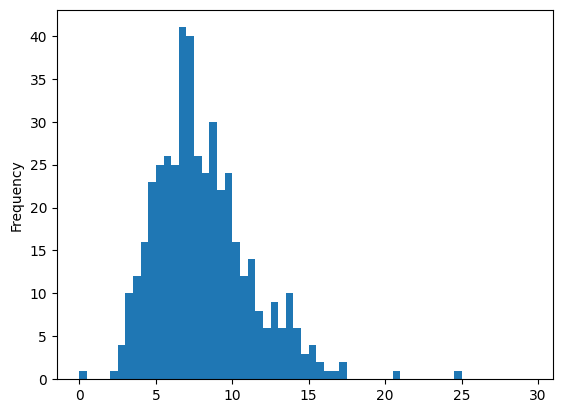

In [29]:
dfavg = df.copy()
dfavg["avg_time_quiz"]  = dfavg.drop_duplicates(subset=["userId","exerciseId"]).groupby(["userId"])["timeSpent_quiz"].transform('mean')
dfavg.drop_duplicates(subset="userId")["avg_time_quiz"].plot(kind='hist', bins=np.arange(0, 30, .5))
dfavg.drop_duplicates(subset="userId")["avg_time_quiz"].describe()

In [30]:
grade_ana = df.copy()

In [31]:
grade_ana["grade"] = grade_ana["userGrades"].apply(lambda x: x.get("grade_out_of_6") if x is not None else None)
grade_ana["grade"].describe()
grade_ana["grade_group"] = pd.cut(grade_ana["grade"], bins=[0, 4, 5, 6], labels=["Low", "Medium", "High"])

In [32]:
print(grade_ana.drop_duplicates("userId")["grade_group"].value_counts())

grade_group
Medium    224
High      140
Low        88
Name: count, dtype: int64


Quiz #1 - Merge Sort - Low - r : 2.7300464704714287 - e : 2.790309128329999 - 0.9296732078894506
Quiz #1 - Merge Sort - Medium - r : 2.4154575468123594 - e : 2.1033049052414285 - 0.4209202261366122
Quiz #1 - Merge Sort - High - r : 2.2413197330272725 - e : 1.7047084500020835 - 0.11746576212148856
Quiz #1 - Merge Sort - 327
Quiz #1 - Insertion Sort - Low - r : 6.313178600618517 - e : 4.076766323186956 - 0.03111875637377564
Quiz #1 - Insertion Sort - Medium - r : 5.9298212506545465 - e : 4.603416094890667 - 0.02635288468079057
Quiz #1 - Insertion Sort - High - r : 5.165336546471154 - e : 4.375122573132653 - 0.2636816035395485
Quiz #1 - Insertion Sort - 303
Quiz #2 - Maximum Sum Subarray - Low - r : 11.685957822844443 - e : 10.940104732684615 - 0.7151524167833347
Quiz #2 - Maximum Sum Subarray - Medium - r : 10.850461169443056 - e : 8.077681278151353 - 0.01545559393201606
Quiz #2 - Maximum Sum Subarray - High - r : 6.98596542037037 - e : 6.318563949081481 - 0.4551545770588592
Quiz #2 - Ma

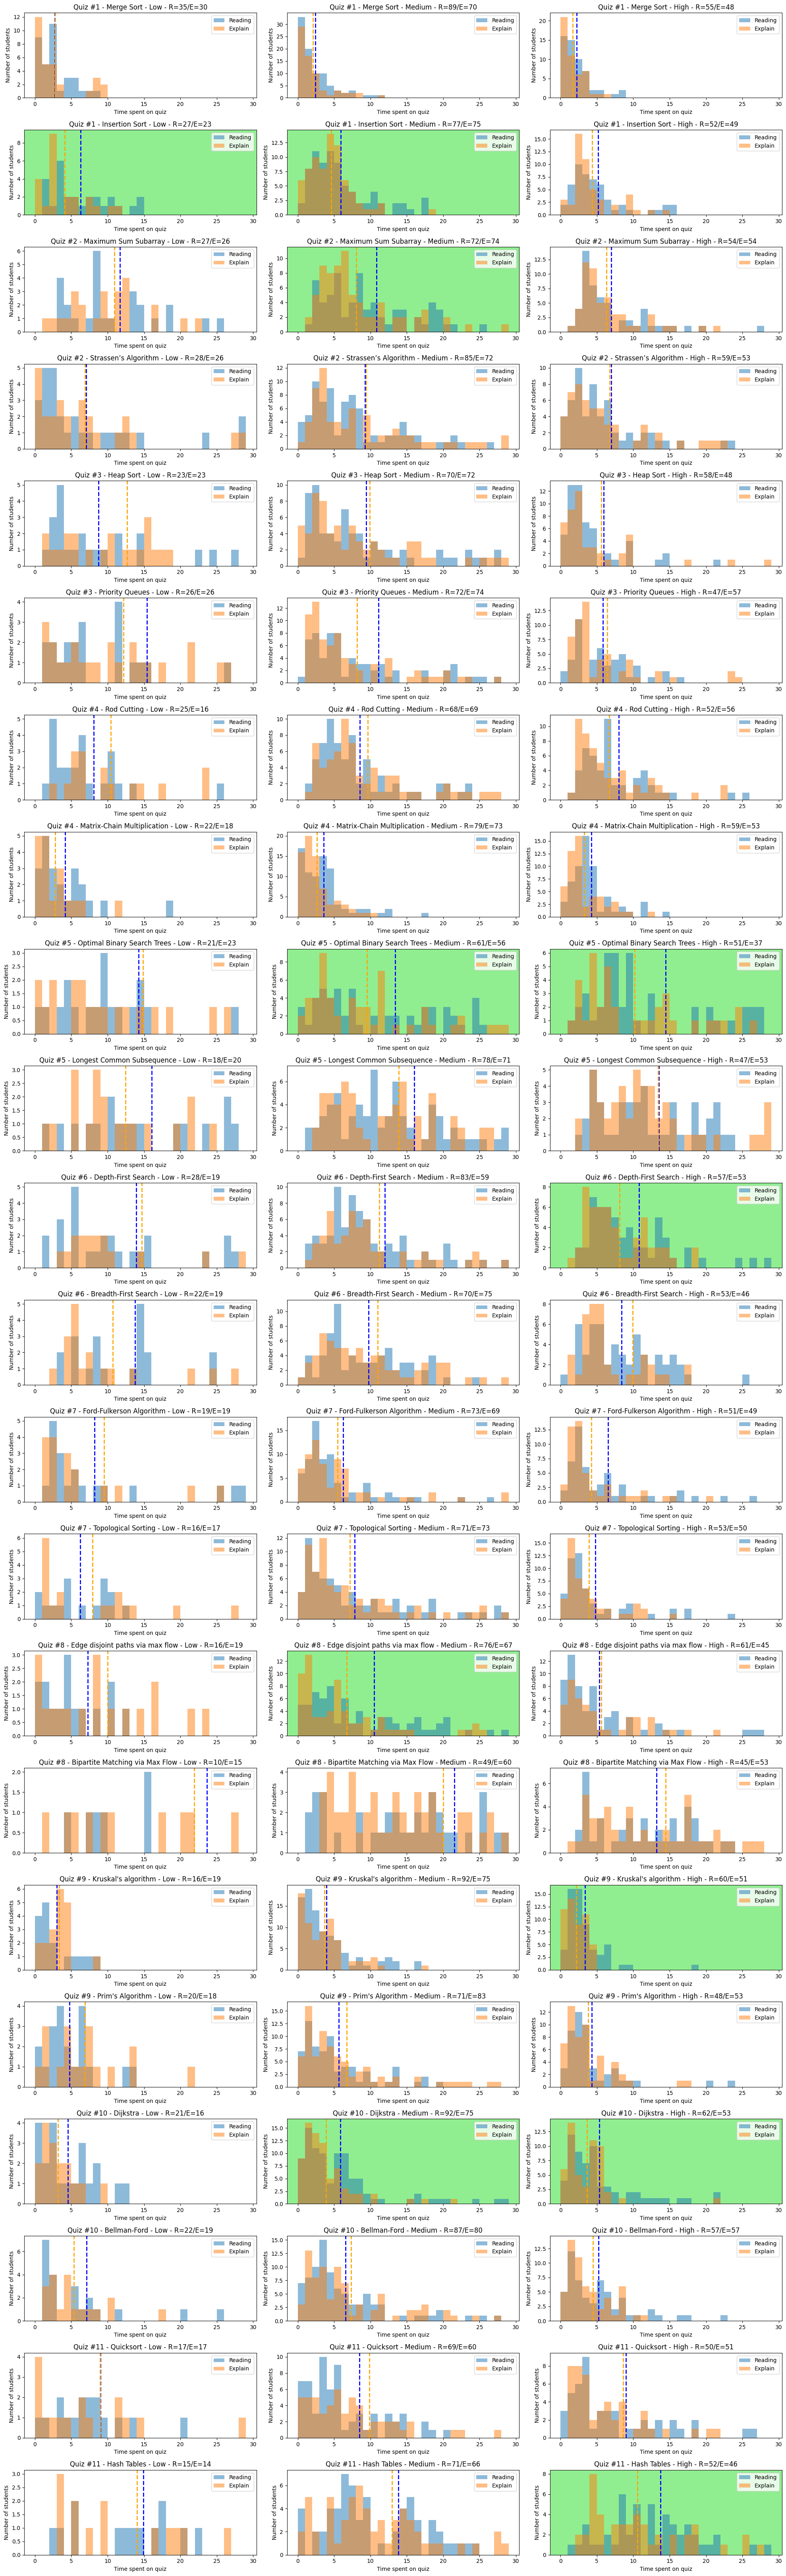

In [33]:
fig, axs = plt.subplots(22,3, figsize=(20, 65))
gg = ["Low", "Medium", "High"]
for i,week in enumerate(weeks):
    for j,ex in enumerate(grade_ana.query("week==@week")["exerciseName"].unique()):
        tot = 0
        for k,group in enumerate(gg):
            read = grade_ana.query("variant == 'reading' and week == @week and exerciseName == @ex and grade_group == @group").drop_duplicates(subset=["userId"])["timeSpent_quiz"]
            explain = grade_ana.query("variant == 'explain' and week == @week and exerciseName == @ex and grade_group == @group").drop_duplicates(subset=["userId"])["timeSpent_quiz"]
            bins = np.arange(0, 30, 1)
            read.plot(kind="hist", bins=bins, ax=axs[2*i+j,k],alpha=0.5, label="Reading")
            explain.plot(kind="hist", bins=bins, ax=axs[2*i+j,k],alpha=0.5, label="Explain")
            axs[2*i+j,k].set_title(f"{week} - {ex} - {group} - R={len(read)}/E={len(explain)}")
            ttest = stats.ttest_ind(read, explain, equal_var=False)
            axs[2*i+j,k].axvline(read.mean(), color='blue', linestyle='dashed', linewidth=2)
            axs[2*i+j,k].axvline(explain.mean(), color='orange', linestyle='dashed', linewidth=2)
            test = stats.ttest_ind(read,explain,equal_var=False)
            axs[2*i+j,k].set_xlabel("Time spent on quiz")
            axs[2*i+j,k].set_ylabel("Number of students")
            axs[2*i+j,k].legend()
            if test.pvalue < 0.05:
                axs[2*i+j,k].set_facecolor('lightgreen')
            tot += len(read)+len(explain)
            print(f"{week} - {ex} - {group} - r : {read.mean()} - e : {explain.mean()} - {test.pvalue}")
        print(f"{week} - {ex} - {tot}")
plt.legend()
plt.tight_layout(
)
plt.show()


Low: Reading mean: 9.15, Explaining mean: 9.19, p-value: 0.95
Medium: Reading mean: 8.83, Explaining mean: 8.18, p-value: 0.04
High: Reading mean: 7.28, Explaining mean: 6.52, p-value: 0.01


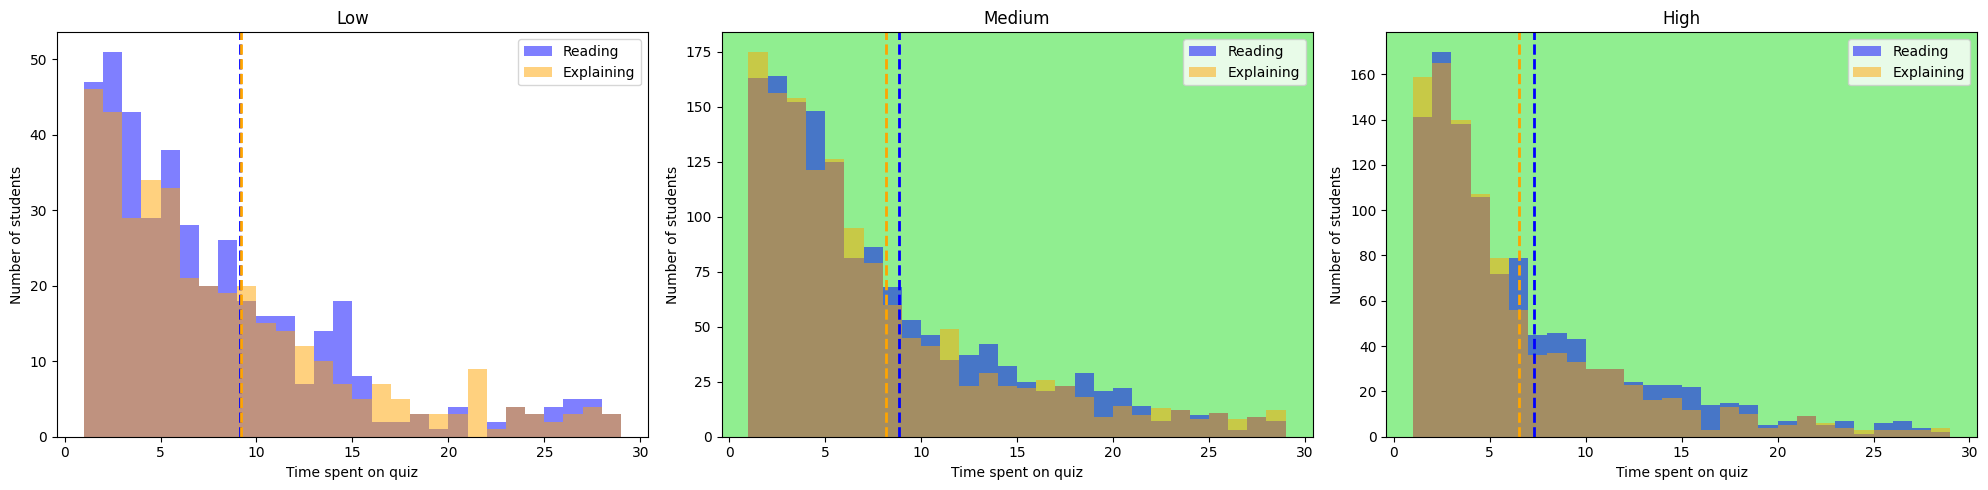

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
bins = np.arange(1, 30,1)
for i,group in enumerate(gg):
    read = grade_ana.query("variant == 'reading' and grade_group == @group").drop_duplicates(subset=["userId","exerciseName"])["timeSpent_quiz"]
    explain = grade_ana.query("variant == 'explain' and grade_group == @group").drop_duplicates(subset=["userId","exerciseName"])["timeSpent_quiz"]
    read.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Reading', color='blue')
    explain.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Explaining', color='orange')
    ax[i].set_xlabel("Time spent on quiz")
    ax[i].set_ylabel("Number of students")
    ax[i].set_title(group)
    ax[i].axvline(read.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax[i].axvline(explain.mean(), color='orange', linestyle='dashed', linewidth=2)
    ttest = stats.ttest_ind(read, explain)
    if ttest.pvalue < 0.05:
        ax[i].set_facecolor('lightgreen')
    print(f"{group}: Reading mean: {read.mean():.2f}, Explaining mean: {explain.mean():.2f}, p-value: {ttest.pvalue:.2f}")
    ax[i].legend()
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups_overlay.png')
plt.show()

87 85
Low: Reading mean: 9.00, Explaining mean: 8.77, p-value: 0.7437149714551523
224 223
Medium: Reading mean: 8.79, Explaining mean: 8.11, p-value: 0.06520584755478141
140 140
High: Reading mean: 7.23, Explaining mean: 6.65, p-value: 0.10700732599393264


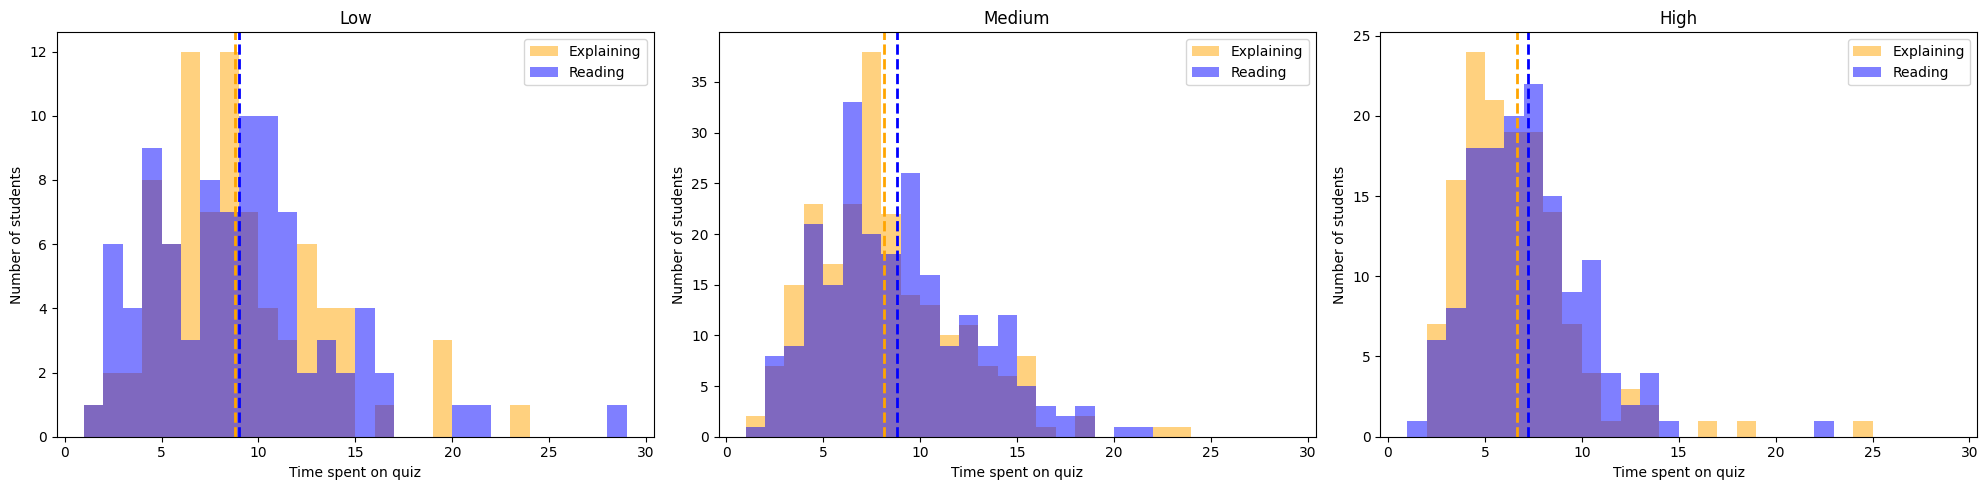

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
bins = np.arange(1, 30,1)
for i,group in enumerate(gg):
    read = (grade_ana
            .query("variant == 'reading' and grade_group == @group")  # Step 1: Filter the data
            .drop_duplicates(subset=["userId", "exerciseName"])        # Step 2: Drop duplicates
            .groupby("userId", as_index=False)                         # Step 3: Group by userId
            ["timeSpent_quiz"].mean().drop_duplicates("userId")["timeSpent_quiz"])        # Step 4: Calculate mean time spent on quiz)     
    explain = (grade_ana
            .query("variant == 'explain' and grade_group == @group")  # Step 1: Filter the data
            .drop_duplicates(subset=["userId", "exerciseName"])        # Step 2: Drop duplicates
            .groupby("userId", as_index=False)                         # Step 3: Group by userId
            ["timeSpent_quiz"].mean().drop_duplicates("userId")["timeSpent_quiz"])     
    print(len(read),len(explain))
    explain.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Explaining', color='orange')
    read.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Reading', color='blue')
    ax[i].set_xlabel("Time spent on quiz")
    ax[i].set_ylabel("Number of students")
    ax[i].set_title(group)
    ax[i].axvline(read.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax[i].axvline(explain.mean(), color='orange', linestyle='dashed', linewidth=2)
    ttest = stats.ttest_ind(read, explain)
    if ttest.pvalue < 0.05:
        ax[i].set_facecolor('lightgreen')
    print(f"{group}: Reading mean: {read.mean():.2f}, Explaining mean: {explain.mean():.2f}, p-value: {ttest.pvalue}")
    ax[i].legend()
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups_overlay.png')
plt.show()

# Text Analysis

In [36]:
txt_ana = df.copy()
txt_ana["content_sys_usr"] = txt_ana["content"] + '\n' + txt_ana["content_usr"]
txt_ana["combined_txt"]=txt_ana.query("type in ['messageSent','answerGenerated']").drop_duplicates(
    subset="systemMessageId").sort_values("_creationTime").groupby(["userId","exerciseId"])["content_sys_usr"].transform(
    lambda x: '\n'.join(x))
print(txt_ana["combined_txt"].dropna().iloc[10])

Great! Could you start by explaining what the rod cutting problem is?
Hello! I'm here to explain to you how to solve the rod cutting problem using dynamic programming!
I see. And how does dynamic programming approach help in solving this problem? What is the basic idea behind this approach?
basically, we have a rod of size n, and we want to cut it in pieces in such a way to maximize the price
Interesting! Could you explain a bit more about how the bottom-up approach works in this problem? How do you start with the smallest subproblems and build up to the solution?
the basic idea would be to use a bottom up or a top down approach to divide the problem into smaller subproblems and cutting the rod of length i<n each time in such a way to maximize the profit
I'm following along. So, if I understand correctly, you're saying that for each rod of length i, we consider all possible cuts up to i, and choose the one that gives the maximum price. This process is repeated for all rod lengths from 

In [37]:
txt_ana["combined_usr"] = txt_ana.query("type in ['answerGenerated','messageSent']").drop_duplicates(
    subset="systemMessageId").sort_values("_creationTime").groupby(["userId","exerciseId"])["content_usr"].transform(
    lambda x: '\n'.join(x))
print(txt_ana["combined_usr"].dropna().iloc[10])

Hello! I'm here to explain to you how to solve the rod cutting problem using dynamic programming!
basically, we have a rod of size n, and we want to cut it in pieces in such a way to maximize the price
the basic idea would be to use a bottom up or a top down approach to divide the problem into smaller subproblems and cutting the rod of length i<n each time in such a way to maximize the profit
you will start by a rod of length 1 to n, ;et's denote the index i,  and the idea will be at each step (using a recursive algorithm thus) either cutting a rod of length i or using the previous optimal solution for i-1 and cutting the rod from i-1 to i. depending on which cut yields a higher price
yes. but the idea is that for a rod of length i, you use your solution for the smaller rods that you had previously computed without having to recompute\
yes. in dynamic programming, you wanna store the previous solutions, so that you then use them to build up solutions to your main problem. thus permitti

<Axes: ylabel='Frequency'>

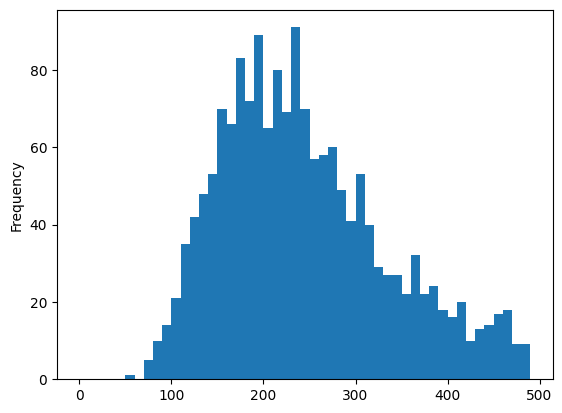

In [38]:
txt_ana["len_txt"] = txt_ana["combined_usr"].dropna().apply(lambda x: len(x.split()))
txt_ana.drop_duplicates(subset=["userId","exerciseName"])["len_txt"].plot(kind='hist', bins=np.arange(0, 500, 10))

In [39]:
from bertopic import BERTopic

In [41]:
topic_model = BERTopic(language="english")

In [46]:
s1 = txt_ana["combined_usr"].dropna().unique()
s1

array(["Hello! I'm here to explain to you how to solve the rod cutting problem using dynamic programming!\nokay so the rod cutting problem is like this : you have a rod of a lenght k. You can sell a rod bar at a price defined by his lenght. So to resolve this problem you actually have a table with all the prices corrsponding to the rod bar lenght. The goal of the problem is to sell your rod bar by cutting (or not ?) and then sell all his parts to obtain the maximum money.\nokay, now come the dynamic programming !\n\nTo solve this problem, you have to make a choice : how to make the leftmost side cut of your rod bar?\n\nYou can define a memory c of the lenght of your entire lenght of your rod bar(let'say n). this memory will contain the obtimal price of the rod bar of length of the index.\n\nSo you have this relation : c[i] = max (for 0<=k<=i-1) (c[k] + c[n-k]);\n\nthen you can easily make your aglorithms to solve this problem with dynamic programming\nyou can initialize this array with

In [47]:
topics, _ = topic_model.fit_transform(s1)

In [48]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18,-1_merge_array_sorted_you,"[merge, array, sorted, you, sort, two, the, di...",[Hello! I'm here to explain the Merge Sort alg...
1,0,157,0_priority_heap_element_key,"[priority, heap, element, key, queue, with, th...",[Hi! I'm here to explain how you can implement...
2,1,157,1_negative_shortest_weight_bellmanford,"[negative, shortest, weight, bellmanford, cycl...",[Hi! I'm here to explain the Bellman-Ford algo...
3,2,154,2_sum_subarray_maximum_array,"[sum, subarray, maximum, array, midpoint, the,...",[Hello! I'm here to explain how to find the ma...
4,3,154,3_tree_prims_mst_minimum,"[tree, prims, mst, minimum, spanning, vertex, ...",[Hi! I'm here to explain Prim's algorithm to y...
5,4,151,4_matrix_matrices_multiplication_strassens,"[matrix, matrices, multiplication, strassens, ...",[Hello! I'm here to explain Strassen's algorit...
6,5,145,5_kruskals_edge_edges_tree,"[kruskals, edge, edges, tree, spanning, cycle,...",[Hi! I'm here to explain Kruskal's algorithm t...
7,6,145,6_lcs_subsequence_longest_common,"[lcs, subsequence, longest, common, the, seque...",[Hi! I'm here to explain the dynamic programmi...
8,7,144,7_matrices_multiplication_optimal_chain,"[matrices, multiplication, optimal, chain, of,...",[Hi! I'm here to explain how to solve the matr...
9,8,143,8_distance_shortest_dijkstras_node,"[distance, shortest, dijkstras, node, the, alg...",[Hi! I'm here to explain Dijkstra's algorithm!...
